## Uso y aplicación de los métodos de agrupamiento

Aprendizaje no supervisado

- Jaime Díaz González (coordinador)
- Jordi Tudela (secretario)
- Alvaro Navarro Guzmán (revisor)

In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

#### DataSet 1: Lung Disease

The first 5 variables are all blood tests which are thought
to be sensitive to liver disorders that might arise from
excessive alcohol consumption.

https://archive.ics.uci.edu/ml/datasets/liver+disorders

In [2]:
nms=["Mean corpuscular volume", "alkaline phosphotase","alanine aminotransferase", "aspartate aminotransferase",
     "gamma-glutamyl transpeptidase","half-pint aquivalents per day", "split"]

lung=pd.read_table('DataSets/Liver_Disease.csv', sep=';', names =nms )

#Eliminamos la variable "etiqueta" de este dataset y de esta forma transformamos el set de datos en uno en el que 
#desconocemos el agrupamiento.
lung=lung.iloc[:,0:6]
lung.sample(5)

,Mean corpuscular volume,alkaline phosphotase,alanine aminotransferase,aspartate aminotransferase,gamma-glutamyl transpeptidase,half-pint aquivalents per day
220,84,88,28,25,35,0.5
21,93,23,35,20,20,0.5
232,98,74,148,75,159,0.5
129,90,74,19,14,22,4.0
126,92,73,24,21,48,4.0


#### DataSet 2: Zoo Animals

A simple database containing 17 Boolean-valued attributes. The idea is to relate this descriptors with an specific class of animal.

https://archive.ics.uci.edu/ml/datasets/zoo

In [3]:
zoo=pd.read_table('DataSets/Zoo_DataSet.csv', sep=';' , 
                  names = ["animal name", "hair", "feathers", "eggs","milk", "airborne", "aquatic", 
                           "predator", "toothed", "backbone", "breathes","venomous", "fins", "legs",
                           "tail", "domestic", "catsize", "type" ])

#Este será el set de datos del que conocemos el agrupamiento real
zoo.sample(5)

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
12,chub,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
89,toad,0,0,1,0,0,1,0,1,1,1,0,0,4,0,0,0,5
78,skimmer,0,1,1,0,1,1,1,0,1,1,0,0,2,1,0,0,2
79,skua,0,1,1,0,1,1,1,0,1,1,0,0,2,1,0,0,2
50,mongoose,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


#### 0. PREPROCESADO

In [4]:
# DataSet 1: Enfermedad del pulmón
####################################

# Eliminamos las filas en las que haya algún NaN
lung.dropna(inplace=True)

#Estandarizamos las columnas del dataset, de esta forma no habrá ninguna columna que pese más por el rago
#dinámico en el que se mueve y tienda a sesgar la descomposición en componentes principales.
standardizer = preprocessing.StandardScaler()
lung_std = standardizer.fit_transform(lung.astype('float64'))

# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_lung = pca.fit_transform(lung_std.astype('float64'))
principal_lung = pd.DataFrame(data = PCs_lung[:,:2], columns = ['PC 1', 'PC 2'])

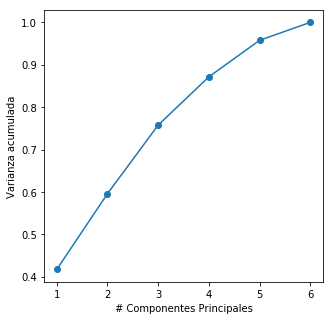

In [5]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(1,len(nms)), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

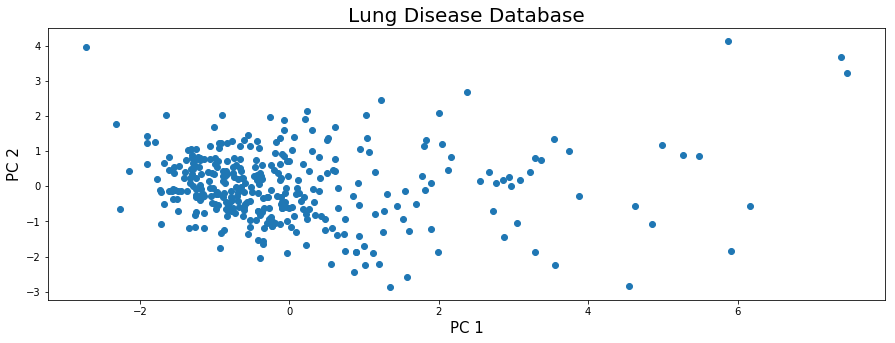

In [6]:
#Pese a que la varianza explicada es baja (~60%), trabajaremos con dos PCs para facilitar la visualización
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_lung[:,0],PCs_lung[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Lung Disease Database', fontsize = 20)
plt.show()

In [7]:
# DataSet 2: Animales del Zoo
#################################

# Separamos la primera y la última columna del dataframe
zoo_label=zoo.iloc[:,-1]
zoo=zoo.iloc[:,1:-1]


# Eliminamos las filas en las que haya algún NaN
zoo.dropna(inplace=True)
#Estandarizamos las columnas del dataset
standardizer = preprocessing.StandardScaler()
zoo_std = standardizer.fit_transform(zoo.astype('float64'))
# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_zoo = pca.fit_transform(zoo_std.astype('float64'))
principal_zoo = pd.DataFrame(data = PCs_zoo[:,:2], columns = ['PC 1', 'PC 2'])

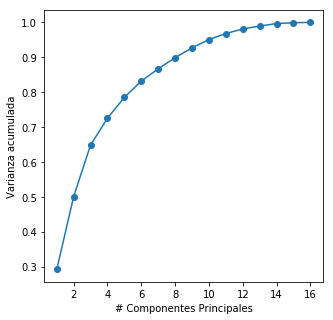

In [8]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(1, zoo.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

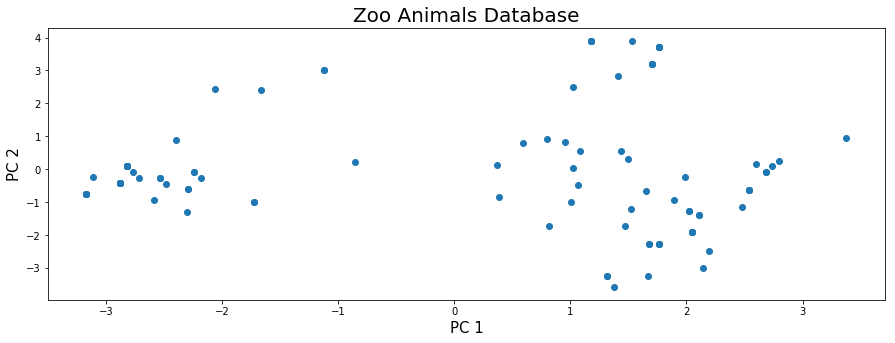

In [9]:
#En este caso, la varianza explicada es incluso menos (~50%), pero seguiremos usando dos PCs por las mismas
#razones, para facilitar una visualización 2D.

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_zoo[:,0],PCs_zoo[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Zoo Animals Database', fontsize = 20)
plt.show()

##### A. Evaluación extrínseca

In [10]:
#Definimos las medidas de evaluación extrínseca

def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    if np.isnan(rec) or np.isnan(prec):
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))

    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def encontrar_mejor_clustering(resultados):
    return np.argmax(resultados)

def imprimir_evaluacion_extrinseca(mC):
    print('\nMedidas extrínsecas:')
    print('  El valor del error cometido es = ', medida_error(mC.T))
    print('  La pureza del agrupamiento = ', medida_pureza(mC))
    print('  La medida F1 = ', medida_f1(mC))

##### B. Evaluación intrínseca

In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabaz_score

def imprimir_evaluacion_intrinseca(silueta, dataset, y_pred):
    print('\nMedidas intrínsecas:')
    print('  Silhouette = ', silueta)
    print('  Calinski-Harabaz = ', calinski_harabaz_score(dataset,y_pred))
    #print('  Davies-Buldin = ', davies_bouldin_score(dataset,y_pred))

#### 1. AGRUPAMIENTO POR PARTICIONES

#### DataSet 1

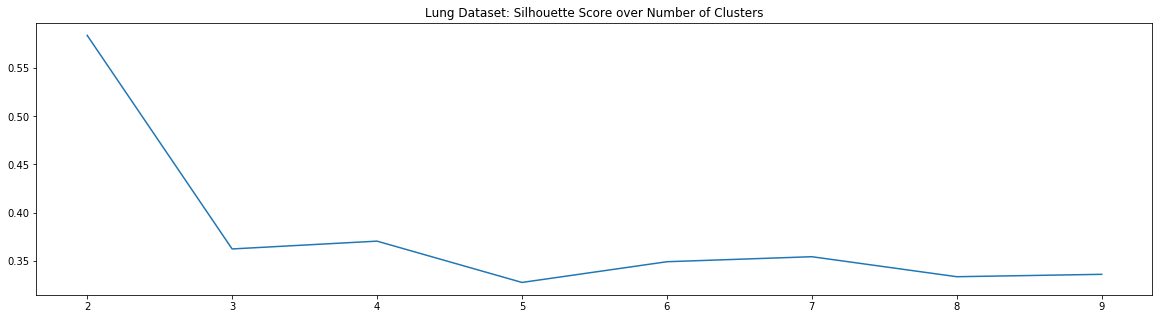

(345,)


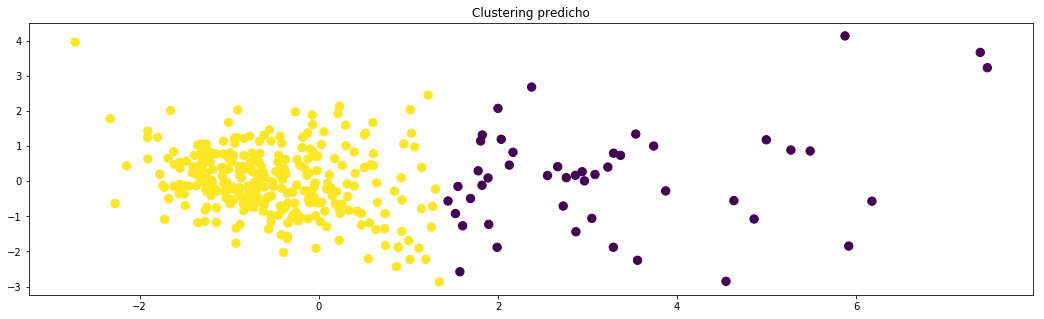

El mejor agrupamiento tiene 2 clusters:

Medidas intrínsecas:
  Silhouette =  0.584131375650844
  Calinski-Harabaz =  295.1469949217652


In [12]:
from sklearn.cluster import KMeans

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(2)

# Explorar la bondad del agrupamiento en función al número de clusters
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

scores = []
for n_clusters in range(MIN_CLUSTERS,MAX_CLUSTERS):
    clf = KMeans(n_clusters=n_clusters)
    y_pred = clf.fit_predict(principal_lung)
    scores.append( silhouette_score(principal_lung ,y_pred) )

plt.figure(figsize=(20,5))
plt.plot(list(range(MIN_CLUSTERS,MAX_CLUSTERS)), scores )
plt.title("Lung Dataset: Silhouette Score over Number of Clusters")
plt.show()

# Aplicar el mejor resultado
best_n_clusters = np.argmax(scores)
y_pred = KMeans(n_clusters=MIN_CLUSTERS + best_n_clusters).fit_predict(principal_lung)

print(y_pred.shape)

# Mostrar resultados
fig = plt.figure(figsize=(18,5))
plt.title('Clustering predicho')
plt.scatter(PCs_lung[:,0], PCs_lung[:,1], c=y_pred, s=70)
plt.show()

print("El mejor agrupamiento tiene {} clusters:".format(MIN_CLUSTERS + best_n_clusters))

score = silhouette_score(principal_lung, y_pred)
imprimir_evaluacion_intrinseca(score, principal_lung, y_pred)
ds_1_eval_part=score

#### DataSet 2

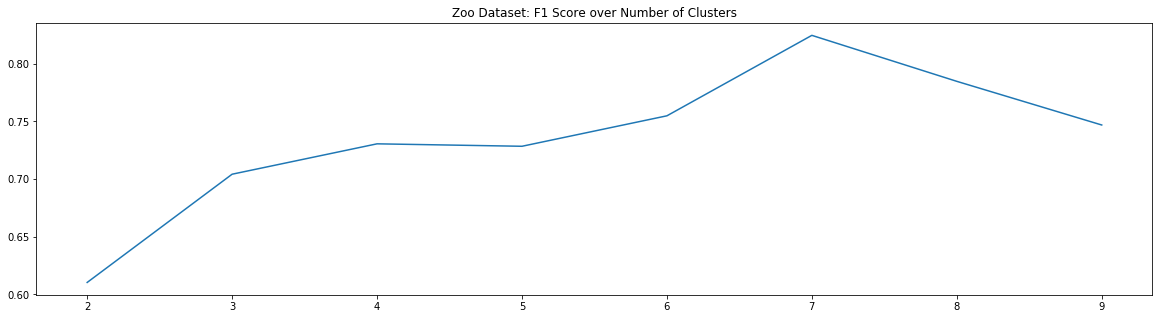

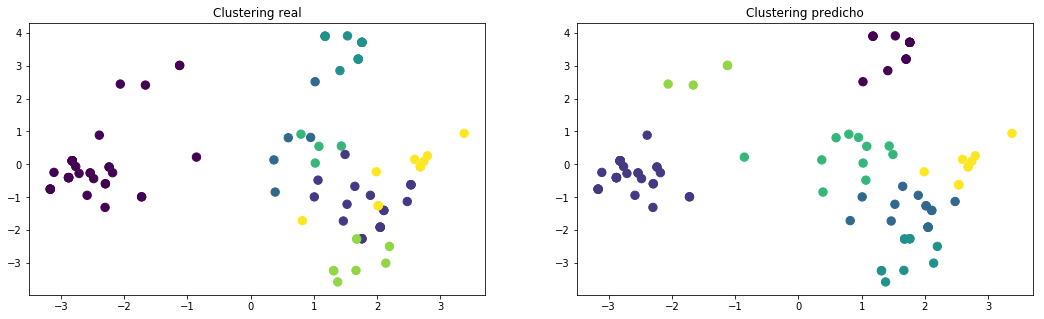

El mejor agrupamiento tiene 7 clusters:

Medidas extrínsecas:
  El valor del error cometido es =  0.16831683168316836
  La pureza del agrupamiento =  0.8316831683168316
  La medida F1 =  0.8211944753372581

Medidas intrínsecas:
  Silhouette =  0.6184631077710698
  Calinski-Harabaz =  348.18526551890255


In [13]:
from sklearn.cluster import KMeans

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(2)

# Explorar la bondad del agrupamiento en función al número de clusters
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

f1_scores = []
for n_clusters in range(MIN_CLUSTERS,MAX_CLUSTERS):
    clf = KMeans(n_clusters=n_clusters)
    y_pred = clf.fit_predict(principal_zoo)
    confusion = matriz_confusion(zoo_label.values,y_pred)
    f1_scores.append( medida_f1(confusion) )

plt.figure(figsize=(20,5))
plt.plot(list(range(MIN_CLUSTERS,MAX_CLUSTERS)), f1_scores )
plt.title("Zoo Dataset: F1 Score over Number of Clusters")
plt.show()

# Aplicar el mejor resultado
best_n_clusters = np.argmax(f1_scores)
y_pred = KMeans(n_clusters=MIN_CLUSTERS + best_n_clusters).fit_predict(principal_zoo)
mC = matriz_confusion(zoo_label.values, y_pred)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(18,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c=zoo_label, s=70)
ax[1].set_title('Clustering predicho')
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c=y_pred, s=70)
plt.show()

print("El mejor agrupamiento tiene {} clusters:".format(MIN_CLUSTERS + best_n_clusters))
imprimir_evaluacion_extrinseca(mC)

imprimir_evaluacion_intrinseca(silhouette_score(principal_zoo,y_pred), principal_zoo, y_pred)

ds_2_eval_part=medida_f1(mC)

#### 2. AGRUPAMIENTO JERÁRQUICO

#### DataSet 1

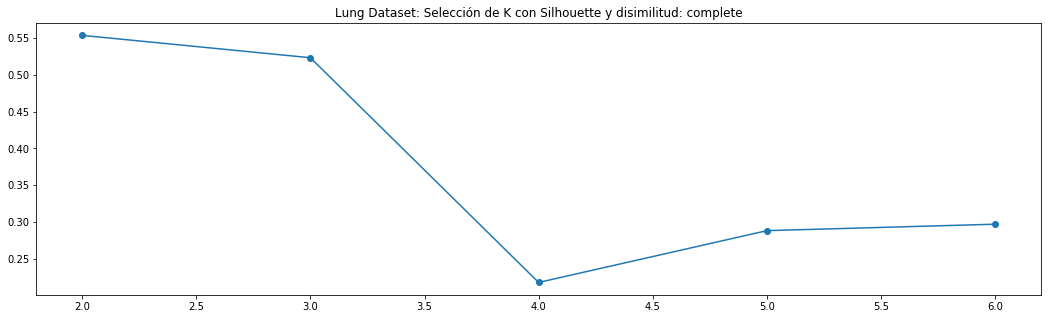

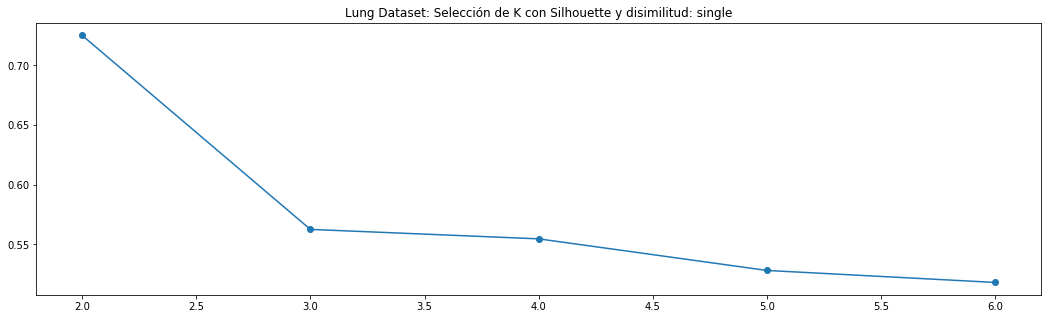

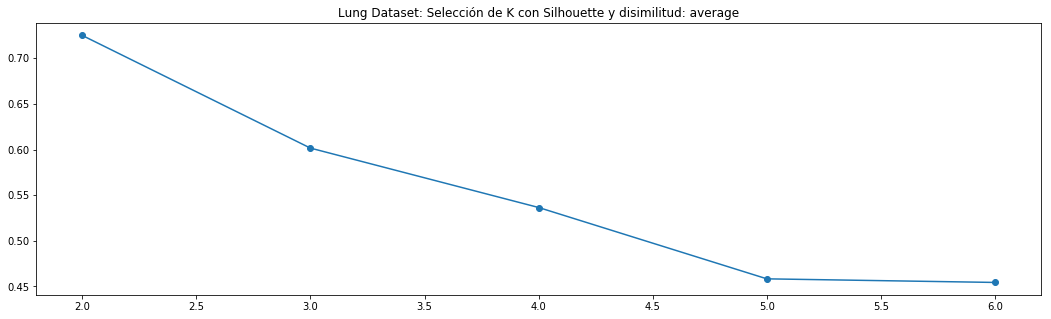

In [14]:
# Utilizamos la libreria scipy por ser la más completa en clustering jerárquico aglomerativo
from scipy.cluster.hierarchy import linkage, cut_tree

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(3)

disimilitudes = {'single', 'complete', 'average'}

# El número de veces que vamos a probar distintos parámetros
total_pruebas = 7

# Lo necesito para saber cuál es la mejor disimilitud
disimilitudes_ejecutadas = []

calidades_clustering = []
calidades_clustering_disimilitud = []
set_k = []
for disimilitud in disimilitudes:
    
    for k in range(2, total_pruebas):
        clustering = linkage(principal_lung, disimilitud)
        
        labels_predicted = cut_tree(clustering, n_clusters=k).flatten()
        
        eval=silhouette_score(principal_lung,list(labels_predicted))
        
        # Guardamos el valor de silueta de cada k
        calidades_clustering.append(eval)
        calidades_clustering_disimilitud.append(eval)
        
        disimilitudes_ejecutadas.append(disimilitud)
        
        #Guardamos el valor de cada k
        set_k.append(k)
    
    plt.figure(figsize=(18,5))
    plt.plot(range(2, total_pruebas), calidades_clustering_disimilitud, 'o-')
    plt.title("Lung Dataset: Selección de K con Silhouette y disimilitud: " + disimilitud)
    plt.show()    
    calidades_clustering_disimilitud = []

El mejor K es = 4
La mejor medida de disimilitud es = complete


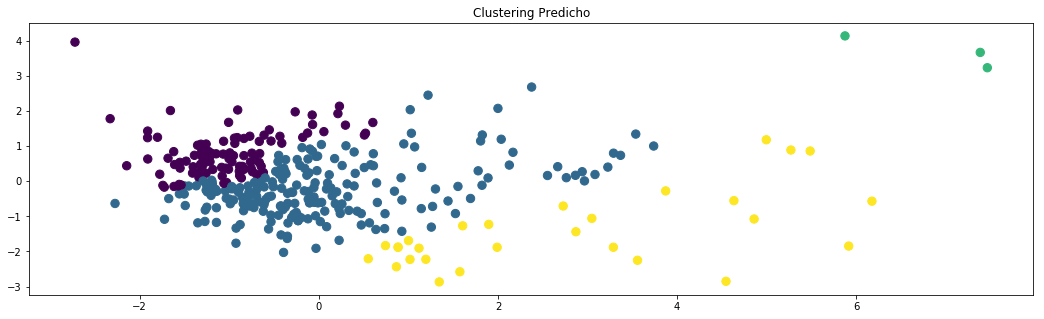


Medidas intrínsecas:
  Silhouette =  0.2178998443889259
  Calinski-Harabaz =  122.02169883291238


In [15]:
# Haciendo uso de la regla del codo y viendo las gráficas, podemos comprobar que la mejor
# disimilitud es "complete" (máxima) y con un k = 4
k=4
disim = 'complete'
print("El mejor K es = " + str(k))
print("La mejor medida de disimilitud es = " + str(disim))


# Repetimos el clustering con la solución que dé la elbow-criteria
##################################################################################
clustering = linkage(principal_lung, disim)
labels_predicted = cut_tree(clustering, n_clusters=k).flatten()
    
# Mostrar resultados
fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Clustering Predicho')
ax.scatter(PCs_lung[:,0], PCs_lung[:,1], c = labels_predicted, s=70)
plt.show()

imprimir_evaluacion_intrinseca(calidades_clustering[k-2], principal_lung, labels_predicted)

ds_1_eval_jerar=set_k[k-2]

#### DataSet 2

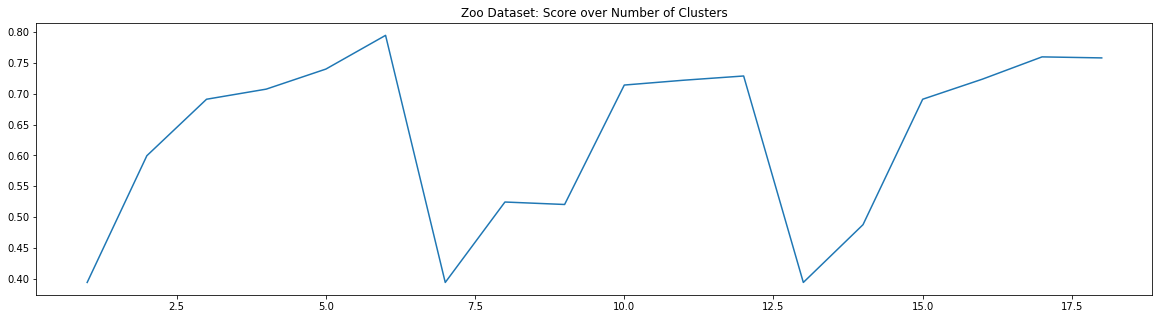

El mejor k es = 6
La mejor medida de disimilitud es = complete

Medidas extrínsecas:
  El valor del error cometido es =  0.19801980198019797
  La pureza del agrupamiento =  0.8019801980198019
  La medida F1 =  0.7769654353664329

Medidas intrínsecas:
  Silhouette =  0.573639879112295
  Calinski-Harabaz =  266.3731740527637


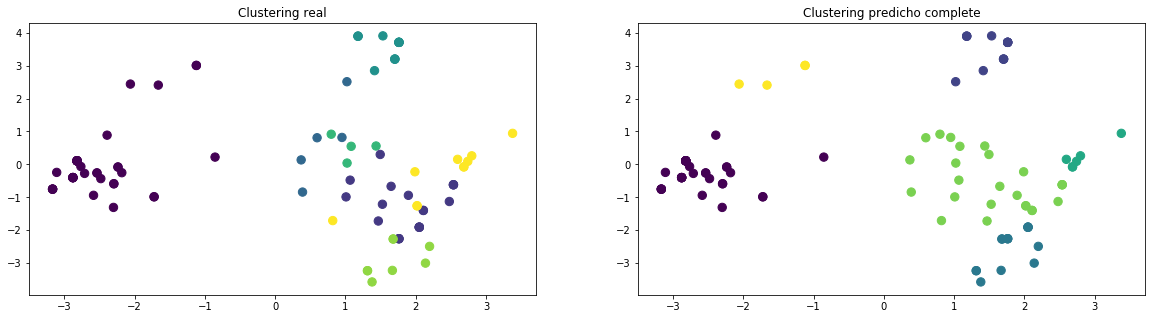

In [16]:
# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(4)

disimilitudes = {'single', 'complete', 'average'}

# El número de veces que vamos a probar distintos parámetros
total_pruebas = 7

# Lo necesito para saber cuál es la mejor disimilitud
disimilitudes_ejecutadas = []

calidades_clustering = []
for disimilitud in disimilitudes:
    
    for k in range(1, total_pruebas):
        clustering = linkage(principal_zoo, disimilitud)

         # Calculamos la matriz de confusión
        mC = matriz_confusion(zoo_label, cut_tree(clustering, n_clusters=k).flatten())

        # Para calcular la calidad total del clustering, asignamos unos pesos a las distintas medidas.
        # Por ejemplo, nos parece más importante la medida del error que el de la pureza
        calidad_total = 0.5 * (1 - medida_error(mC.T)) +  0.2 * medida_pureza(mC) + 0.3 * medida_f1(mC)

        calidades_clustering.append(calidad_total)
        disimilitudes_ejecutadas.append(disimilitud)
        
plt.figure(figsize=(20,5))
plt.plot(list(range(1, len(disimilitudes_ejecutadas)+1)), calidades_clustering )
plt.title("Zoo Dataset: Score over Number of Clusters")
plt.show()

# Recojo el índice del mejor clustering
indice_mejor = encontrar_mejor_clustering(calidades_clustering)

# Sumo 1 porque en el bucle anterior he empezado por un k = 1
mejor_k = encontrar_mejor_clustering(calidades_clustering)%(total_pruebas-1) + 1

mejor_disimilitud = disimilitudes_ejecutadas[indice_mejor]

print("El mejor k es = " + str(mejor_k))
print("La mejor medida de disimilitud es = " + mejor_disimilitud)

# Repetimos el clustering con la solución que optimiza la variable 'mejor_disimilitud'
##################################################################################

clustering = linkage(principal_zoo, mejor_disimilitud)

# Calculamos la matriz de confusión
y_pred = cut_tree(clustering, n_clusters=mejor_k).flatten()
mC = matriz_confusion(zoo_label, y_pred)

imprimir_evaluacion_extrinseca(mC)

imprimir_evaluacion_intrinseca(silhouette_score(principal_zoo,y_pred), principal_zoo, y_pred)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = zoo_label, s=70)
ax[1].set_title('Clustering predicho ' + mejor_disimilitud)
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c=cut_tree(clustering, n_clusters=mejor_k).flatten(), s=70)
plt.show()


ds_2_eval_jerar=medida_f1(mC)

#### 3. AGRUPAMIENTO ESPECTRAL

#### DataSet 1

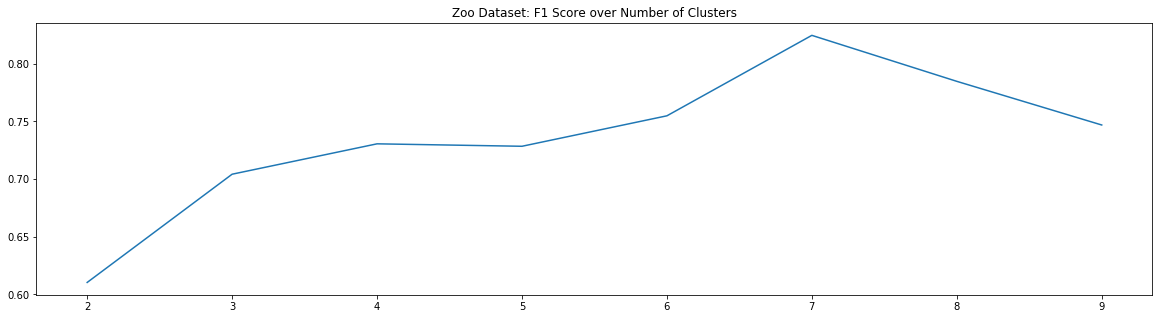

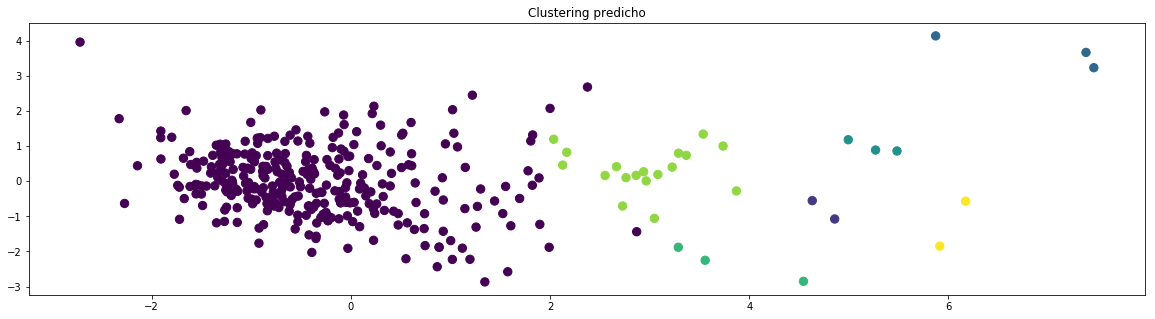

El mejor agrupamiento tiene 7 clusters:

Medidas intrínsecas:
  Silhouette =  0.5030022413024144
  Calinski-Harabaz =  64.20309793536175


In [17]:
from sklearn.cluster import SpectralClustering

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(6)

# Explorar la bondad del agrupamiento en función al número de clusters
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

scores = []
for n_clusters in range(MIN_CLUSTERS,MAX_CLUSTERS):
    clf = SpectralClustering(n_clusters=n_clusters)
    y_pred = clf.fit_predict(principal_lung)
    scores.append( silhouette_score(principal_lung, y_pred) )

plt.figure(figsize=(20,5))
plt.plot(list(range(MIN_CLUSTERS,MAX_CLUSTERS)), f1_scores )
plt.title("Zoo Dataset: F1 Score over Number of Clusters")
plt.show()

# Aplicar el mejor resultado
best_n_clusters = np.argmax(f1_scores)
y_pred = SpectralClustering(n_clusters=MIN_CLUSTERS + best_n_clusters).fit_predict(principal_lung)

# Mostrar resultados
fig = plt.figure(figsize=(20,5))
plt.title('Clustering predicho')
plt.scatter(PCs_lung[:,0], PCs_lung[:,1], c=y_pred, s=70)
plt.show()

print("El mejor agrupamiento tiene {} clusters:".format(MIN_CLUSTERS + best_n_clusters))

score = silhouette_score(principal_lung, y_pred)
imprimir_evaluacion_intrinseca(score, principal_lung, y_pred)
ds_1_eval_spect=score

#### DataSet 2

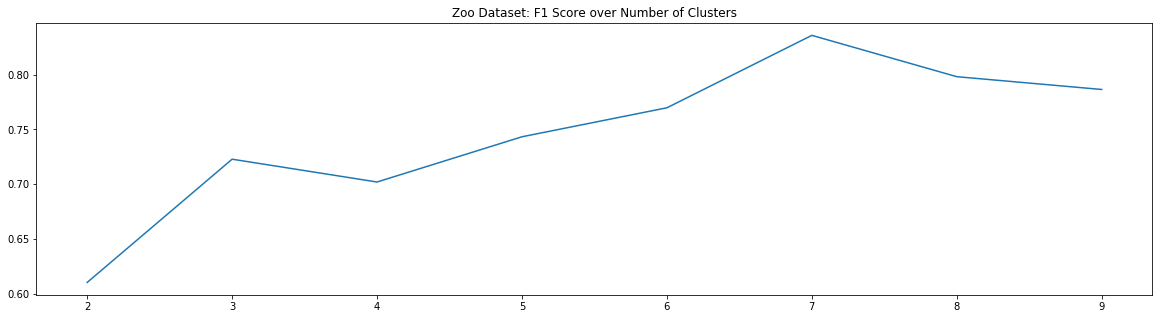

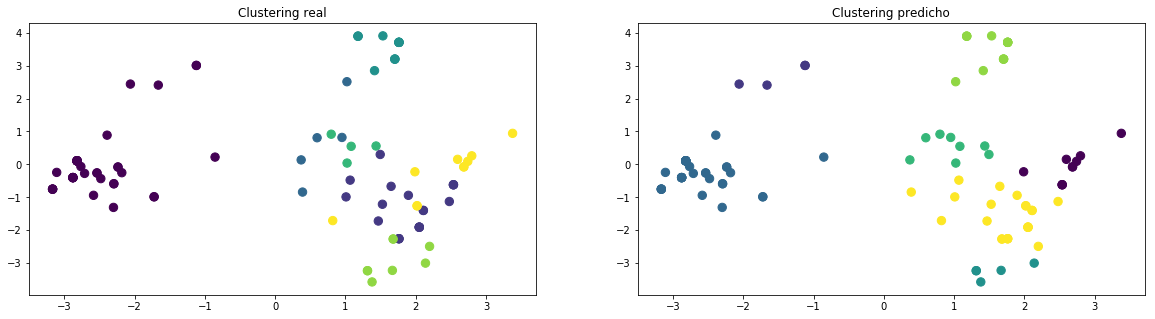

El mejor agrupamiento tiene 7 clusters:

Medidas extrínsecas:
  El valor del error cometido es =  0.14851485148514854
  La pureza del agrupamiento =  0.8514851485148516
  La medida F1 =  0.8359196086573475

Medidas intrínsecas:
  Silhouette =  0.6147335786538709
  Calinski-Harabaz =  319.08849428273277


In [18]:
from sklearn.cluster import SpectralClustering

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(6)

# Explorar la bondad del agrupamiento en función al número de clusters
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

f1_scores = []
for n_clusters in range(MIN_CLUSTERS,MAX_CLUSTERS):
    clf = SpectralClustering(n_clusters=n_clusters)
    y_pred = clf.fit_predict(principal_zoo)
    confusion = matriz_confusion(zoo_label.values,y_pred)
    f1_scores.append( medida_f1(confusion) )

plt.figure(figsize=(20,5))
plt.plot(list(range(MIN_CLUSTERS,MAX_CLUSTERS)), f1_scores )
plt.title("Zoo Dataset: F1 Score over Number of Clusters")
plt.show()

# Aplicar el mejor resultado
best_n_clusters = np.argmax(f1_scores)
y_pred = SpectralClustering(n_clusters=MIN_CLUSTERS + best_n_clusters).fit_predict(principal_zoo)
mC = matriz_confusion(zoo_label.values, y_pred)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c=zoo_label, s=70)
ax[1].set_title('Clustering predicho')
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c=y_pred, s=70)
plt.show()

print("El mejor agrupamiento tiene {} clusters:".format(MIN_CLUSTERS + best_n_clusters))
imprimir_evaluacion_extrinseca(mC)

imprimir_evaluacion_intrinseca(silhouette_score(principal_zoo,y_pred), principal_zoo, y_pred)

ds_2_eval_spect=medida_f1(mC)

#### 4. AGRUPAMIENTO POR DENSIDAD

#### DataSet 1

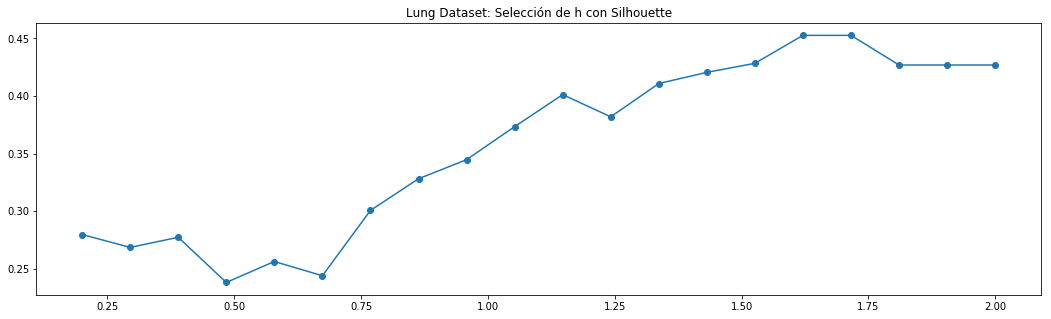

In [19]:
# Vamos a utilizar el método de desplazamiento de media
from sklearn.cluster import MeanShift

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(7)

# Rango dinámico del tamaño de kernel que vamos a estudiar
total_pruebas = np.linspace(0.2,2,20)

calidades_clustering = []
set_h = []
for h in total_pruebas:
    
    clustering = MeanShift(bandwidth = h).fit(principal_lung)
    
    # Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
    clustering.labels_  = clustering.labels_ + 1

    eval=silhouette_score(principal_lung,clustering.labels_)

    # Guardamos el valor de silueta de cada h
    calidades_clustering.append(eval)
    
    #Guardamos el valor de cada h
    set_h.append(h)

plt.figure(figsize=(18,5))
plt.plot(list(total_pruebas), calidades_clustering, 'o-')
plt.title("Lung Dataset: Selección de h con Silhouette")
plt.show()

El mejor h es = 0.4842105263157895


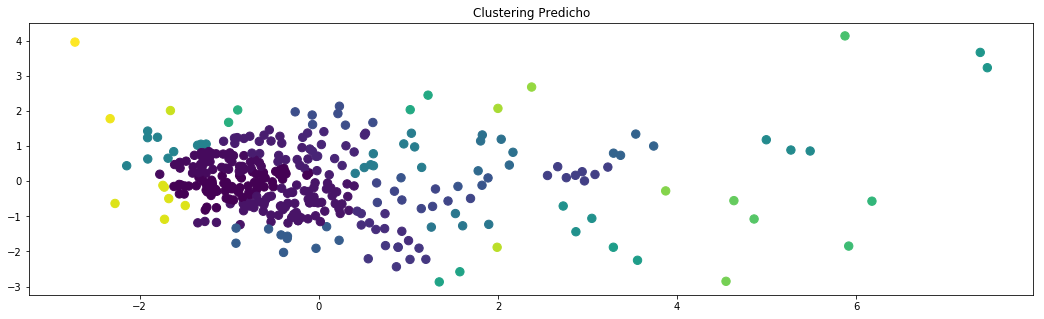


Medidas intrínsecas:
  Silhouette =  0.4842105263157895
  Calinski-Harabaz =  162.187459630938


In [20]:
#Haciendo uso de la regla del codo, establecemos h cerca de 0.50, visualmente sabemos que es el índice 3 de set_h
indice_h = 3
h = set_h[indice_h]
print("El mejor h es = " + str(h))


# Repetimos el clustering con la solución que dé la elbow-criteria
##################################################################################

clustering = MeanShift(bandwidth = h).fit(principal_lung)
    
# Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
clustering.labels_  = clustering.labels_ + 1
    
# Mostrar resultados
fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Clustering Predicho')
ax.scatter(PCs_lung[:,0], PCs_lung[:,1], c = clustering.labels_, s=70)
plt.show()

imprimir_evaluacion_intrinseca(set_h[indice_h], principal_lung, clustering.labels_)

ds_1_eval_densi=set_h[indice_h]

#### DataSet 2

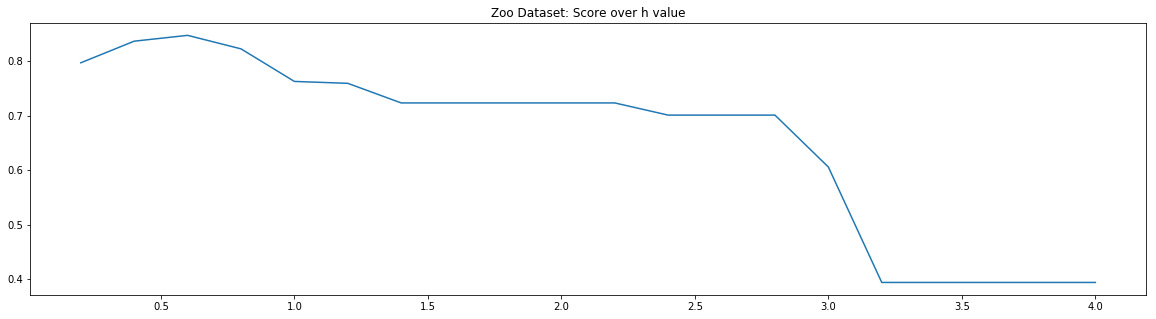

El mejor h es = 0.6


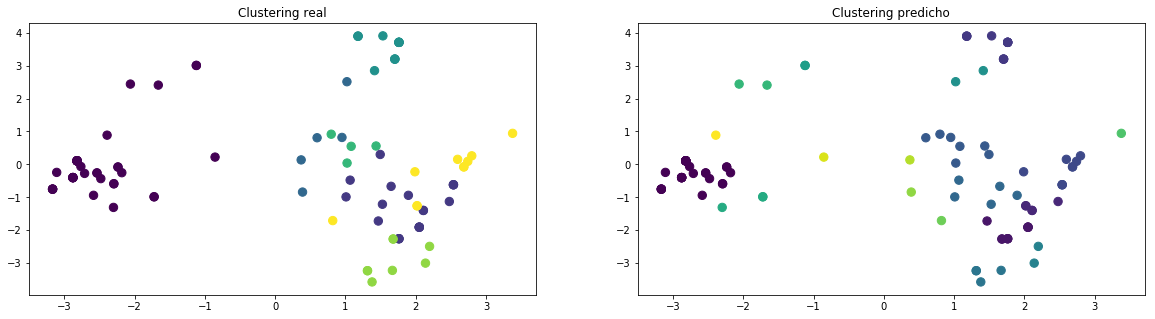


Medidas extrínsecas:
  El valor del error cometido es =  0.1089108910891089
  La pureza del agrupamiento =  0.8910891089108912
  La medida F1 =  0.7457104210781569

Medidas intrínsecas:
  Silhouette =  0.4494799596355106
  Calinski-Harabaz =  319.08849428273277


In [21]:
# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(8)

# Rango dinámico del tamaño de kernel que vamos a estudiar
total_pruebas = np.linspace(0.2,4,20)

calidades_clustering = []
for h in total_pruebas:
    clustering = MeanShift(bandwidth = h).fit(principal_zoo)
    
    # Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
    clustering.labels_  = clustering.labels_ + 1
    
    # Calculamos la matriz de confusión
    mC = matriz_confusion(zoo_label, clustering.labels_)
    
    # Para calcular la calidad total del clustering, asignamos unos pesos a las distintas medidas.
    # Por ejemplo, nos parece más importante la medida del error que el de la pureza
    calidad_total = 0.5 * (1 - medida_error(mC.T)) +  0.2 * medida_pureza(mC) + 0.3 * medida_f1(mC)
    
    calidades_clustering.append(calidad_total)
    
plt.figure(figsize=(20,5))
plt.plot(list(total_pruebas), calidades_clustering )
plt.title("Zoo Dataset: Score over h value")
plt.show()

#Posicion del mejor clustering
mejor_h = encontrar_mejor_clustering(calidades_clustering) 

print("El mejor h es = " + str(total_pruebas[mejor_h]))


# Repetimos el clustering con la solución que optimiza la variable 'calidad_total'
##################################################################################

clustering = MeanShift(bandwidth = total_pruebas[mejor_h]).fit(principal_zoo)
    
# Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
clustering.labels_  = clustering.labels_ + 1
    
# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = zoo_label, s=70)
ax[1].set_title('Clustering predicho')
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = clustering.labels_, s=70)
plt.show()

# Calculamos la matriz de confusión
mC = matriz_confusion(zoo_label, clustering.labels_)

imprimir_evaluacion_extrinseca(mC)

imprimir_evaluacion_intrinseca(silhouette_score(principal_zoo,clustering.labels_), principal_zoo, y_pred)

ds_2_eval_densi=medida_f1(mC)

#### 5. AGRUPAMIENTO PROBABILÍSTICO

#### DataSet 1

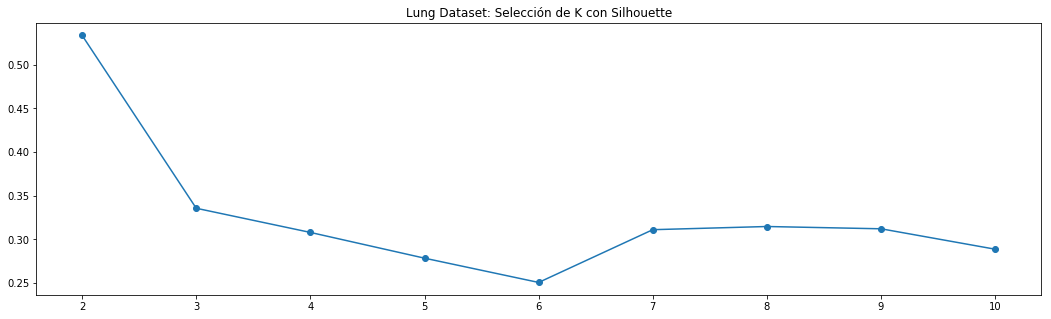

In [22]:
# Vamos a utilizar el método de mixtura gaussiana
from sklearn.mixture import GaussianMixture
import random

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(9)

# Al tratarse de un método probabilístico y no determinista, tenemos que elegir el modelo que mejor funcione 
# dentro de la batería de pruebas que se realizan para saber cuál es el mejor valor de K.
# Este método depende en gran medida de la inicialización, de esta forma habrá que realizar varias medidas repetidas
# con el mismo valor de K y escoger la que mejor funcione (en base a los criterios de validación)

# Rango dinámico del tamaño de kernel que vamos a estudiar
total_clusters = range(2,11)

new_init=[]
set_k=[]
set_model_1=[]
set_model_2=[]

for k in range(2,11):
    
    #Realizamos 50 inicializaciones y elegimos la que mejor score se extraiga de la funcion silhouette
    for it in range(50):

        modelo = GaussianMixture(n_components = k, max_iter = 200).fit(principal_lung)
        labels_predicted = modelo.predict(principal_lung)

        eval=silhouette_score(principal_lung,labels_predicted)
        
        new_init.append(eval)
        set_model_1.append(modelo)
    
    #Nos quedamos con un valor de silhouette por cada valor de número de clusters
    set_model_2.append(set_model_1[np.argmax(eval)])
    set_k.append(np.max(eval))
    set_model_1=[]

plt.figure(figsize=(18,5))
plt.plot(list(range(2,11)), set_k, 'o-')
plt.title("Lung Dataset: Selección de K con Silhouette")
plt.show()
    


El mejor K es = 3


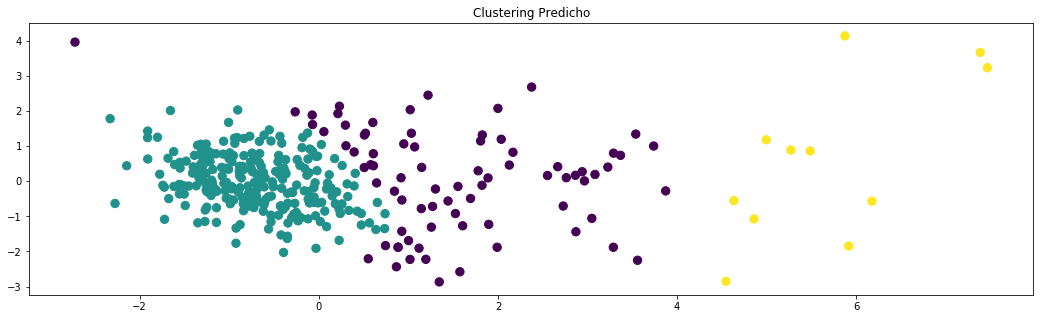


Medidas intrínsecas:
  Silhouette =  0.3356958230062145
  Calinski-Harabaz =  199.14463650829038


In [23]:

#Haciendo uso de la regla del codo, establecemos K=3
k=3
print("El mejor K es = " + str(k))


# Repetimos el clustering con la solución que dé la elbow-criteria
##################################################################################

modelo_final= set_model_2[k-2]
labels_predicted = modelo_final.predict(principal_lung)
    
# Mostrar resultados
fig, ax = plt.subplots(figsize=(18,5))
ax.set_title('Clustering Predicho')
ax.scatter(PCs_lung[:,0], PCs_lung[:,1], c = labels_predicted, s=70)
plt.show()

imprimir_evaluacion_intrinseca(set_k[k-2], principal_lung, labels_predicted)

ds_1_eval_prob=set_k[k-2]

#### DataSet 2

El mejor K es = 9

Medidas extrínsecas:
  El valor del error cometido es =  0.13861386138613863
  La pureza del agrupamiento =  0.8613861386138614
  La medida F1 =  0.8050797753768051

Medidas intrínsecas:
  Silhouette =  0.6066635830143084
  Calinski-Harabaz =  305.7298900820355


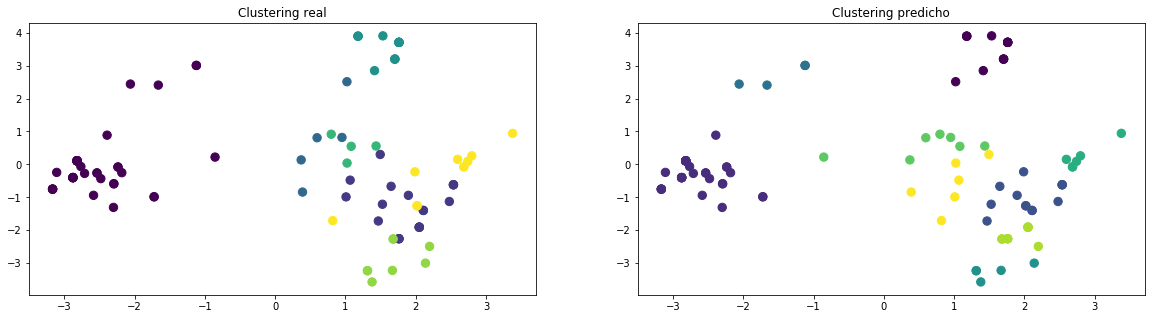

In [24]:
# Vamos a utilizar el método de mixtura gaussiana

# Ponemos una semilla para asegurar la reproducibilidad de los resultados
np.random.seed(10)

# Al tratarse de un método probabilístico y no determinista, tenemos que elegir el modelo que mejor funcione 
# dentro de la batería de pruebas que se realizan para saber cuál es el mejor valor de K.
# Este método depende en gran medida de la inicialización, de esta forma habrá que realizar varias medidas repetidas
# con el mismo valor de K y escoger la que mejor funcione (en base a los criterios de validación)

# Rango dinámico del tamaño de kernel que vamos a estudiar
total_clusters = range(1,11)

calidades_clustering = []
set_modelos=[]
set_k=[]

for it in range(200):
    
    k=random.randrange(1, 11, 1)

    modelo = GaussianMixture(n_components = k, max_iter = 200).fit(principal_zoo)
    labels_predicted = modelo.predict(principal_zoo)
    
    # Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
    labels_predicted  = labels_predicted + 1
    
    # Calculamos la matriz de confusión
    mC = matriz_confusion(zoo_label, labels_predicted)
    
    # Para calcular la calidad total del clustering, asignamos unos pesos a las distintas medidas.
    # Por ejemplo, nos parece más importante la medida del error que el de la pureza
    calidad_total = 0.5 * (1 - medida_error(mC.T)) +  0.2 * medida_pureza(mC) + 0.3 * medida_f1(mC)
    
    calidades_clustering.append(calidad_total)
    set_modelos.append(modelo)
    set_k.append(k)

#Posicion del mejor clustering
mejor_h = encontrar_mejor_clustering(calidades_clustering) 
print("El mejor K es = " + str(set_k[mejor_h]))


# Repetimos el clustering con la solución que optimiza la variable 'calidad_total'
##################################################################################

modelo_final= set_modelos[mejor_h]
labels_predicted = modelo_final.predict(principal_zoo)

# Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
labels_predicted  = labels_predicted + 1

# Calculamos la matriz de confusión
mC = matriz_confusion(zoo_label, labels_predicted)
    
# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = zoo_label, s=70)
ax[1].set_title('Clustering predicho')
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = labels_predicted, s=70)


imprimir_evaluacion_extrinseca(mC)

imprimir_evaluacion_intrinseca(silhouette_score(principal_zoo,labels_predicted), principal_zoo, labels_predicted)

ds_2_eval_prob=medida_f1(mC)

#### 6. COMPARATIVA

#### DataSet 1

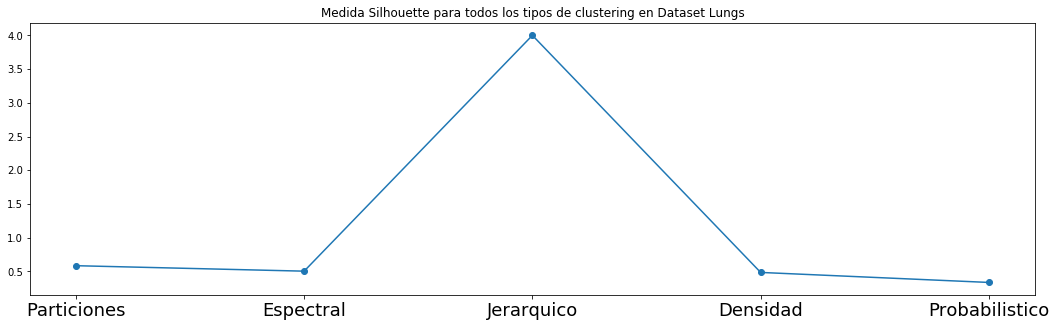

In [25]:
plt.figure(figsize=(18,5))
plt.plot([ds_1_eval_part,ds_1_eval_spect,ds_1_eval_jerar,ds_1_eval_densi,ds_1_eval_prob], 'o-')
plt.title("Medida Silhouette para todos los tipos de clustering en Dataset Lungs")
plt.xticks(range(5), ('Particiones', 'Espectral', 'Jerarquico', 'Densidad', 'Probabilistico'), fontsize=18)
plt.show()

#### DataSet 2

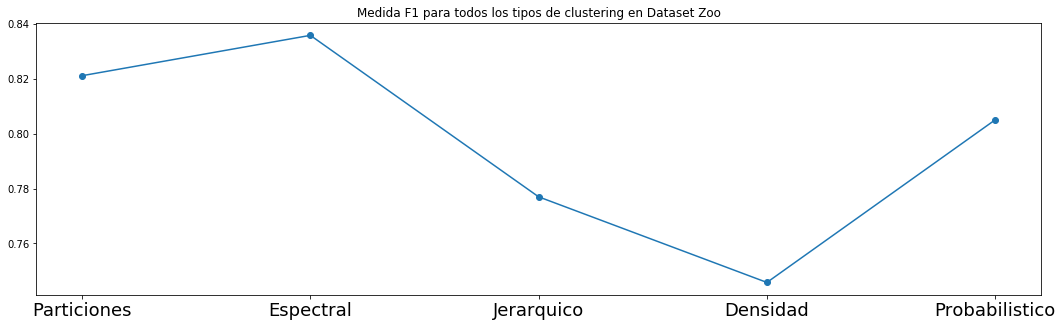

In [26]:
plt.figure(figsize=(18,5))
plt.plot([ds_2_eval_part,ds_2_eval_spect,ds_2_eval_jerar,ds_2_eval_densi,ds_2_eval_prob], 'o-')
plt.title("Medida F1 para todos los tipos de clustering en Dataset Zoo")
plt.xticks(range(5), ('Particiones', 'Espectral', 'Jerarquico', 'Densidad', 'Probabilistico'), fontsize=18)
plt.show()

Como podemos observar, de acuerdo al criterio de evaluación de la medida F1, el clustering espectral es el que cuenta con mayor índice y por tanto el más afín al clustering real. Por el tipo de distribución en el plano 2D, parece que el clustering por densidad sería el menos eficiente.
Aumentando el número de Componentes Principales de 2 a 3 quizá seríamos capaces de aumentar el valor de esta medida de evaluación, sin embargo el objetivo de este trabajo era realizar una medida comparativa, lo más visual posible de este set de métodos.